In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import jsonlines 
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# Set font globally to Helvetica Neue
matplotlib.rcParams['font.family'] = 'Helvetica Neue'

In [81]:
def get_map_value(map_list, map_at):
    """
    map_list is a list of dicts, like:
      [
        {"map@1": 0.8287},
        {"map@5": 0.8823},
        {"map@10": 0.8845},
        {"map@20": 0.8857},
        ...
      ]
    map_at is a string key, e.g. "map@20".
    """
    for d in map_list:
        if map_at in d:
            return d[map_at]
    # Return None or raise an error if the key doesn't exist
    return None

map_idx = {
    "map@1": 0,
    "map@5": 1,
    "map@10": 2,
    "map@20": 3,
    "map@50": 4,
}

def get_map_value_from_list(map_list, map_at):
    """
    Fetches the value from map_list at the position specified by map_at.

    Parameters:
    - map_list: List of map values (e.g., [0.92, 0.93, 0.94, ...]).
    - map_at: String key indicating the desired map (e.g., "map@20").

    Returns:
    - The corresponding value from map_list if valid, else None.
    """
    if map_at in map_idx:
        idx = map_idx[map_at]
        if 0 <= idx < len(map_list):
            return map_list[idx]
    return None


In [82]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap

# Dictionary mapping experiment types to file paths
experiments_dict = {
    "Casing": "../experiments/casing/",
    "Typos": "../experiments/typos/gpt4o/", 
    # "Dialect": "../experiments/dialect/gpt4o/",
    "Negation": "../experiments/negation/gpt4o/",
    # "Entity Replacement": "../experiments/named_entity_replacement/gpt4o/",
    "Rewrite": "../experiments/rewrite/gpt4o/",
    "Amplify/Downplay": "../experiments/amplify_minimize/gpt4o/",
}

type_mapping = {
    "Entity Replacement": {
        "Baseline": "Atleast 1",
        "Worstcase": "All"
    },
    "Dialect": {
        "Baseline": "Least",
        "Worstcase": "Most"
    },
    "Typos": {
        "Baseline": "Least",
        "Worstcase": "Most"
    }, 
    "Casing": {
        "Baseline": "Truecase",
        "Worstcase": "Upper"
    },
    "Rewrite": {
        "Baseline": "Least",
        "Worstcase": "Most"
    },
    "Amplify/Downplay": {
        "Baseline": "Least",
        "Worstcase": "Most"
    },
    "Negation": {
        "Baseline": "Shallow",
        "Worstcase": "Double"
    },
}
def parse_experiment_results(file_path: str, map_at:str = "map@20", after = False):
    """
    Parses MAP@20 differences for a given experiment file.
    """
    print('Trying to open', file_path)  
    with open(file_path) as f:
        results = [json.loads(line) for line in f]

    parsed_results = {}
    map_results = {}
    for model_results in results:
        model_name = next(iter(model_results))
        
        # Now use it in place of direct indexing
        original_baseline_list = model_results[model_name]['original_baseline']['map_results']['test']
        edited_baseline_list   = model_results[model_name]['edited_baseline']['map_results']['test']
        original_worstcase_list = model_results[model_name]['original_worstcase']['map_results']['test']
        edited_worstcase_list   = model_results[model_name]['edited_worstcase']['map_results']['test']

        # if after use a difference map function
        if after:
            map_function = get_map_value_from_list
        else:
            map_function =  get_map_value

        original_baseline   = map_function(original_baseline_list,   map_at)
        edited_baseline     = map_function(edited_baseline_list,     map_at)
        original_worstcase  = map_function(original_worstcase_list,  map_at)
        edited_worstcase    = map_function(edited_worstcase_list,    map_at)

        # Compute differences
        baseline_diff = (edited_baseline - original_baseline) * 100
        worstcase_diff = (edited_worstcase - original_worstcase) * 100

        parsed_results[model_name] = {"Baseline": baseline_diff, "Worstcase": worstcase_diff}
        map_results[model_name] = {"Baseline_MAP": edited_baseline, "Worstcase_MAP": edited_worstcase}

    return pd.DataFrame(parsed_results).T, pd.DataFrame(map_results).T

In [83]:
def plot_all_experiments(experiments_dict, res_path, dataset, dialect_results_df = None, model_order=None, map_at="map@20", after=False, plot_title:str=""):
    """
    Plots a heatmap with experiment names as group labels and types as sub-columns.

    Args:
        experiments_dict (dict): Dictionary mapping experiment names to file paths.
        res_path (str): Relative path to the results file.
        model_order (list): List of model names in the desired order (optional).
    """
    import os
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib
    import cmcrameri.cm as cmc
    import numpy as np

    # Set font globally to Helvetica Neue
    matplotlib.rcParams['font.family'] = 'Helvetica Neue'

    all_results = []

    # Parse results for all experiments
    for experiment, path in experiments_dict.items():
        file_path = os.path.join(path, res_path)
        experiment_df, _ = parse_experiment_results(file_path, map_at, after)

        # Melt the data to long format and tag it with the experiment type
        experiment_df = experiment_df.rename_axis("Model").reset_index()
        experiment_df = pd.melt(
            experiment_df, id_vars="Model", var_name="Type", value_name="Difference"
        )
        experiment_df["Experiment"] = experiment
        all_results.append(experiment_df)

    # Combine all results
    combined_df = pd.concat(all_results, ignore_index=True)

     # Preserve the original 'Type' column for sorting
    combined_df["OriginalType"] = combined_df["Type"]

    # Replace Type labels using the type_mapping dictionary if provided
    if type_mapping:
        combined_df["Type"] = combined_df.apply(
            lambda row: type_mapping.get(row["Experiment"], {}).get(row["Type"], row["Type"]),
            axis=1
        )

    # Enforce Baseline -> Worstcase order using OriginalType
    combined_df["OriginalType"] = pd.Categorical(
        combined_df["OriginalType"],
        categories=["Baseline", "Worstcase"],
        ordered=True
    )

    if dialect_results_df is not None: 
        combined_df = pd.concat([combined_df, dialect_results_df], ignore_index=True)


    # Pivot table to create hierarchical columns (Experiment -> Type)
    heatmap_df = combined_df.pivot_table(
        index="Model", columns=["Experiment", "Type"], values="Difference", sort=False
    )

    # Reorder rows (models) if specified
    if model_order:
        heatmap_df = heatmap_df.reindex(model_order)

    # Prepare annotations
    annot_data = heatmap_df.applymap(lambda x: f"{x:.1f}%" if not np.isnan(x) else "")

    # Set up the heatmap
    cmap = cmc.vik_r
    fig, ax = plt.subplots(figsize=(14, 5))  # Adjust figure size
    sns.heatmap(
        heatmap_df,
        cmap='RdBu',
        annot=annot_data,
        fmt="",
        center=0,
        linewidths=0.5,
        cbar_kws={"orientation": "horizontal", "pad": 0.05, "shrink":0.75},  # Tight color bar
        ax=ax
    )

    cbar = ax.collections[0].colorbar
    cbar.set_label(f"{map_at} Difference after applying edits on {dataset} dataset and reranking", fontsize=10, weight="bold")

    # Move the column headers to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.xticks(rotation=0, ha="center")

    # Add experiment group labels (top-level annotations)
    col_positions = heatmap_df.columns.codes[0]  # Top-level column indices
    col_labels = heatmap_df.columns.levels[0]    # Unique experiment group labels
    last_pos = 0

    for i, label in enumerate(col_labels):
        # Find how many columns belong to this group
        group_count = list(col_positions).count(i)

        # Calculate position for the group label
        center = last_pos + group_count / 2
        plt.text(
            center, -1.4, label, ha="center", va="center", fontsize=11, fontweight="bold"
        )
        last_pos += group_count

        # Draw vertical line after each group
        ax.axvline(last_pos, color="black", linestyle="-", linewidth=0.5)

    # Add x-axis ticks (little lines) for the 'Type' labels
    ax.xaxis.tick_top()  # Move ticks to the top
    ax.xaxis.set_label_position("top")
    # ax.axhline(1, color="black", linestyle="-", linewidth=1)
    # ax.axhline(5, color="black", linestyle="-", linewidth=1)
    # ax.axhline(8, color="black", linestyle="-", linewidth=1)
    # Set x-axis tick positions and labels
    ax.set_xticks([pos + 0.5 for pos in range(len(heatmap_df.columns))])  # Center ticks
    ax.set_xticklabels(
        [col[1] for col in heatmap_df.columns],  # Extract 'Type' labels
        rotation=0,
        ha="center",
        fontsize=10
    )

    # Enable tick marks for the x-axis
    ax.tick_params(
        axis="x",      # Apply to the x-axis
        which="both",  # Enable both major and minor ticks
        length=3.5,      # Length of the tick lines
        width=1,       # Width of the tick lines
        direction="out"  # Draw ticks outward
    )

    # Clear axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y',length=0)  # Remove tick marks for clarity

    # Add a border around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)

    # Adjust layout
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{plot_title}_{dataset}_plot.png', dpi=600, bbox_inches="tight")  # Save with high DPI
    plt.show()

    return combined_df

In [84]:
import json
import pandas as pd

def calculate_map_differences(file_path: str, map_at: str = "map@20", after=False):
    """
    Calculates the MAP@20 differences for each dialect and model.
    Args:
        file_path: Path to the JSON file containing results.
    Returns:
        A pandas DataFrame with models as rows, dialects as columns, and MAP@20 differences as values.
    """
    # Load the data
    results = []
    print('Trying to open', file_path)
    with open(file_path, 'r') as f:
        for line in f:
            results.append(json.loads(line))

    # Initialize a dictionary to store differences
    differences = {}
    map_results = {}
    for entry in results:
        dialect = entry["dialect"]
        for model, model_results in entry.items():
            if model == "dialect":  # Skip dialect key
                continue
            
            # Usage example:
            original_baseline_list = model_results["original_baseline"]["map_results"]["test"]
            edited_baseline_list   = model_results["edited_baseline"]["map_results"]["test"]

            # if after use a difference map function
            if after:
                map_function = get_map_value_from_list
            else:
                map_function =  get_map_value

            original_baseline = map_function(original_baseline_list, map_at)
            edited_baseline   = map_function(edited_baseline_list, map_at)

            # Compute the difference
            map_diff = (edited_baseline - original_baseline) * 100  # Scale to percentage
            
            # Add to dictionary
            if model not in differences:
                differences[model] = {}
            differences[model][dialect] = round(map_diff, 2)

            # Add to map_results dictionary
            if model not in map_results:
                map_results[model] = {}
            if dialect not in map_results[model]:
                map_results[model][dialect] = {}

            map_results[model][dialect] = {
            'Worstcase_MAP': edited_baseline
            }

    # Convert to a pandas DataFrame
    df = pd.DataFrame(differences).T  # Transpose so models are rows, dialects are columns
    df = df.fillna(0)  # Fill missing values with 0
    # print(df)

    # Flatten the map_results dictionary
    map_results_flat = [
        {"Model": model, "Dialect": dialect, **metrics}
        for model, dialect_data in map_results.items()
        for dialect, metrics in dialect_data.items()
    ]
    map_results_df = pd.DataFrame(map_results_flat)

    return df, map_results_df

def parse_dialect_results(file_path: str, map_at: str = "map@20", after=False):
    """
    Parses MAP@20 differences for a given dialect file.
    """
    # File path to the JSON file
    map_differences_df, map_results_df = calculate_map_differences(file_path, map_at, after)
    map_differences_df = map_differences_df.reset_index().rename(columns={"index": "Model"})
    dialect_check_that_df = pd.melt(
        map_differences_df,
        id_vars=["Model"],
        var_name="Type",         # Column names become 'Type'
        value_name="Difference"  # Values become 'Difference'
    )

    # Add Experiment and OriginalType columns
    dialect_check_that_df["Experiment"] = "Dialect"
    dialect_check_that_df["OriginalType"] = "Worstcase"

    # Mapping dictionary to shorten dialect names
    type_mapping_dialects = {
        "african_american_english": "AAE",
        "jamaican_patois": "Jamaican",
        "pidgin": "Pidgin",
        "singlish": "Singlish"
    }

    # Remap the 'Type' column
    dialect_check_that_df["Type"] = dialect_check_that_df["Type"].replace(type_mapping_dialects)
    map_results_df["Dialect"] = map_results_df["Dialect"].replace(type_mapping_dialects)

    return dialect_check_that_df, map_results_df

In [85]:
# The dialect experiments have a different structure, so we need to parse them separately
file_path = "../experiments/dialect/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_dialect_results_all.jsonl"
# dialect_check_that_df_map1, map1 = parse_dialect_results(file_path, map_at="map@1")
# dialect_check_that_df_map10 = parse_dialect_results(file_path, map_at="map@10")
dialect_check_that_df_map20, map20_results = parse_dialect_results(file_path, map_at="map@50")
# dialect_check_that_df_map50 = parse_dialect_results(file_path, map_at="map@50")
# dialect_check_that_df_map100 = parse_dialect_results(file_path, map_at="map@100")

Trying to open ../experiments/dialect/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_dialect_results_all.jsonl


In [86]:
# Parse the dialect results for the Fact-Check-Tweet dataset
fc_file_path = "../experiments/dialect/gpt4o/fact-check-tweet/results/before_reranking_dialect_results_all_final.jsonl"
dialect_fact_check_tweet_df_map20, fact_check_tweet_map20_results = parse_dialect_results(fc_file_path, map_at="map@20", after=True)

Trying to open ../experiments/dialect/gpt4o/fact-check-tweet/results/before_reranking_dialect_results_all_final.jsonl


In [87]:
# Specify custom order for models
custom_model_order = [
    "bm25",
    "all-distilroberta-v1",
    "all-MiniLM-L12-v2",
    "all-mpnet-base-v2",
    "all-mpnet-base-v2-ft",
    "sentence-t5-base",
    "sentence-t5-large",
    "sentence-t5-large-ft",
    "hkunlp/instructor-base",
    "hkunlp/instructor-large",
    "Salesforce/SFR-Embedding-Mistral",
    "nvidia/NV-Embed-v2"
]

# map_ats = ["map@1", "map@10", "map@20", "map@50", "map@100"]
# dialect_results_dfs = [dialect_check_that_df_map1, dialect_check_that_df_map10, dialect_check_that_df_map20, dialect_check_that_df_map50, dialect_check_that_df_map100]

# for map_at, dialect_results_df in zip(map_ats, dialect_results_dfs):
#     print(f"Generating plot for {map_at}")
#     results_df = plot_all_experiments(
#         experiments_dict=experiments_dict,
#         res_path='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl',
#         dataset="CheckThat2022",
#         dialect_results_df=dialect_results_df,
#         model_order=custom_model_order,
#         map_at=map_at
#     )

# # # Run the function with custom model order
# # results_df = plot_all_experiments(experiments_dict, model_order=custom_model_order, res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', map_at = "map@10", dataset="CheckThat2022", dialect_results_df=dialect_check_that_df_map10)
# # results_df = plot_all_experiments(experiments_dict, model_order=custom_model_order, res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', map_at = "map@20", dataset="CheckThat2022", dialect_results_df=dialect_check_that_df_map20)
# # results_df = plot_all_experiments(experiments_dict, model_order=custom_model_order, res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', map_at = "map@50", dataset="CheckThat2022", dialect_results_df=dialect_check_that_df_map50)
# # results_df = plot_all_experiments(experiments_dict, model_order=custom_model_order, res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', map_at = "map@100", dataset="CheckThat2022", dialect_results_df=dialect_check_that_df_map100)

Trying to open ../experiments/casing/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/typos/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/negation/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/rewrite/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl


/tmp/ipykernel_2234771/3959759077.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(lambda x: f"{x:.1f}%" if not np.isnan(x) else "")


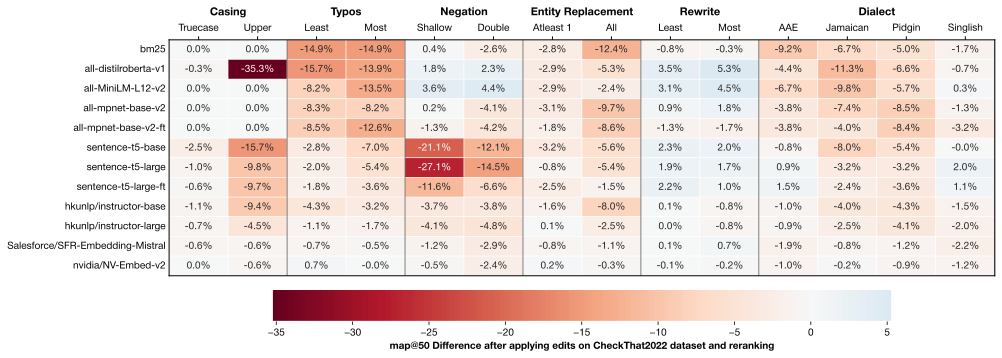

In [66]:
check_that_before_ranking_results_df = plot_all_experiments(experiments_dict,
                                model_order=custom_model_order, 
                                res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', 
                                map_at = "map@50", dataset="CheckThat2022", 
                                dialect_results_df=dialect_check_that_df_map20,
                                plot_title="before_reranking_results_all")

Trying to open ../experiments/casing/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/typos/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/negation/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/rewrite/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/amplify_minimize/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl


/tmp/ipykernel_2234771/3959759077.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(lambda x: f"{x:.1f}%" if not np.isnan(x) else "")


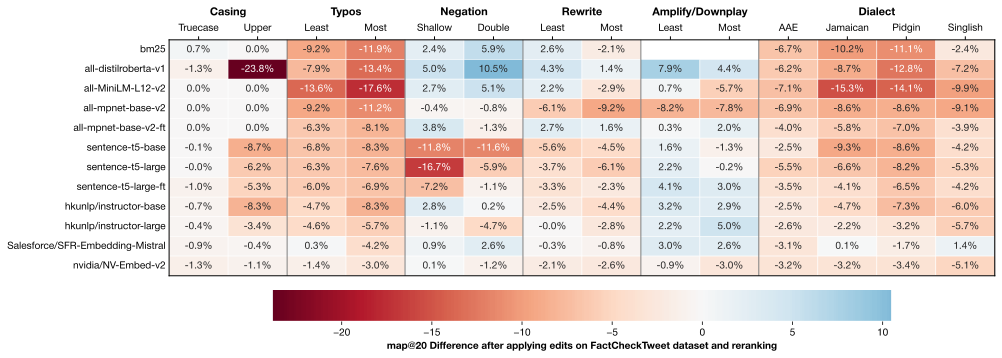

In [51]:
fact_check_results_before_ranking = plot_all_experiments(experiments_dict,
                                        model_order=custom_model_order, 
                                        res_path ='fact-check-tweet/results/before_rerank_results_all.jsonl', 
                                        map_at = "map@20", dataset="FactCheckTweet", 
                                        # after=True,
                                        dialect_results_df=dialect_fact_check_tweet_df_map20,
                                        plot_title="before_reranking_results_all")

In [105]:
map_idx = {
    "map@1": 0,
    "map@5": 1,
    "map@10": 2,
    "map@20": 3,
    "map@50": 4,
}

def get_map_value_from_list(map_list, map_at):
    """
    Fetches the value from map_list at the position specified by map_at.

    Parameters:
    - map_list: List of map values (e.g., [0.92, 0.93, 0.94, ...]).
    - map_at: String key indicating the desired map (e.g., "map@20").

    Returns:
    - The corresponding value from map_list if valid, else None.
    """
    if map_at in map_idx:
        idx = map_idx[map_at]
        if 0 <= idx < len(map_list):
            return map_list[idx]
    elif map_at == "map@50":
        return map_list[-1]
    return None


def parse_experiment_results_after_ranking(file_path: str, map_at:str = "map@20"):
    """
    Parses MAP@20 differences for a given experiment file.
    """
    print('Trying to open', file_path)  
    with open(file_path) as f:
        results = [json.loads(line) for line in f]

    parsed_results = {}
    map_results = {}
    for model_results in results:
        model_name = next(iter(model_results))
        
        # Now use it in place of direct indexing
        original_baseline_list = model_results[model_name]['original_baseline']['map_results']['test']
        edited_baseline_list   = model_results[model_name]['edited_baseline']['map_results']['test']
        original_worstcase_list = model_results[model_name]['original_worstcase']['map_results']['test']
        edited_worstcase_list   = model_results[model_name]['edited_worstcase']['map_results']['test']

        original_baseline   = get_map_value_from_list(original_baseline_list,   map_at)
        edited_baseline     = get_map_value_from_list(edited_baseline_list,     map_at)
        original_worstcase  = get_map_value_from_list(original_worstcase_list,  map_at)
        edited_worstcase    = get_map_value_from_list(edited_worstcase_list,    map_at)

        # Compute differences
        baseline_diff = (edited_baseline - original_baseline) * 100
        worstcase_diff = (edited_worstcase - original_worstcase) * 100

        parsed_results[model_name] = {"Baseline": baseline_diff, 
                                      "Worstcase": worstcase_diff}
        
        map_results[model_name] = {"Baseline_MAP": edited_baseline, "Worstcase_MAP": edited_worstcase}

    return pd.DataFrame(parsed_results).T, pd.DataFrame(map_results).T

In [106]:
import json
import pandas as pd


def calculate_dialect_map_differences(file_path: str, dialect:str, map_at: str = "map@20"):
    """
    Calculates the MAP@20 differences for each dialect and model.
    Args:
        file_path: Path to the JSON file containing results.
    Returns:
        A pandas DataFrame with models as rows, dialects as columns, and MAP@20 differences as values.
    """
    # Load the data
    results = []
    with open(file_path, 'r') as f:
        for line in f:
            results.append(json.loads(line))

    # Initialize a dictionary to store differences and results
    differences = {}
    map_results = {}

    for model_results in results:
        model = next(iter(model_results))

        print(model_results[model])
        
        # Extract original and edited MAP values
        original_baseline_list = model_results[model]["original_baseline"]["map_results"]["test"]
        edited_baseline_list = model_results[model]["edited_baseline"]["map_results"]["test"]

        print(f'Original Baseline List: {original_baseline_list}')
        print(f'Edited Baseline List: {edited_baseline_list}')

        original_baseline = get_map_value_from_list(original_baseline_list, map_at)
        edited_baseline = get_map_value_from_list(edited_baseline_list, map_at)

        print(f'Original Baseline: {original_baseline}')
        print(f'Edited Baseline: {edited_baseline}')

        # Compute the difference
        map_diff = (edited_baseline - original_baseline) * 100  # Scale to percentage

        # Add to dictionaries
        if model not in differences:
            differences[model] = {}
            map_results[model] = {}
        differences[model][dialect] = round(map_diff, 2)
        map_results[model][dialect] = {
            "Baseline_MAP": original_baseline,
            "Worstcase_MAP": edited_baseline,
        }

    # Convert to DataFrames
    df = pd.DataFrame(differences).T  # Transpose so models are rows, dialects are columns
    df = df.fillna(0)  # Fill missing values with 0

    map_results_flat = [
        {"Model": model, "Dialect": dialect, **metrics}
        for model, dialect_data in map_results.items()
        for dialect, metrics in dialect_data.items()
    ]
    map_df = pd.DataFrame(map_results_flat)

    return df, map_df

def parse_dialect_results(file_path: str, map_at: str = "map@20"):
    """
    Parses MAP@20 differences for a given dialect file.
    """
    # File path to the JSON file
    map_differences_df, map_results_df = calculate_map_differences(file_path, map_at)
    map_differences_df = map_differences_df.reset_index().rename(columns={"index": "Model"})
    dialect_check_that_df = pd.melt(
        map_differences_df,
        id_vars=["Model"],
        var_name="Type",         # Column names become 'Type'
        value_name="Difference"  # Values become 'Difference'
    )

    # Add Experiment and OriginalType columns
    dialect_check_that_df["Experiment"] = "Dialect"
    dialect_check_that_df["OriginalType"] = "Worstcase"

    # Mapping dictionary to shorten dialect names
    type_mapping_dialects = {
        "african_american_english": "AAE",
        "jamaican_patois": "Jamaican",
        "pidgin": "Pidgin",
        "singlish": "Singlish"
    }

    # Remap the 'Type' column
    dialect_check_that_df["Type"] = dialect_check_that_df["Type"].replace(type_mapping_dialects)
    map_results_df["Dialect"] = map_results_df["Dialect"].replace(type_mapping_dialects)

    return dialect_check_that_df, map_results_df


def parse_dialect_results_after(dialect_paths: dict, dataset:str, map_at: str = "map@20", map_results_before_df=None):
    """
    Parses MAP@20 differences for a given dialect file.
    """
    all_dialect_results = []
    all_dialecct_e2e_results = []
    for dialect, dialect_path in dialect_paths.items():
        file_path = f'../experiments/dialect/gpt4o/{dataset}/results/{dialect_path}/after_reranking_n_50_candidates_bge_llm_results.jsonl'

        print(f"Processing {file_path} for {dialect} dialect.")
        # Calculate differences and map results
        map_differences_df, map_results_after_df = calculate_dialect_map_differences(file_path, dialect, map_at)

        # Ensure map_results_before_df is provided
        if map_results_before_df is None:
            raise ValueError("map_results_before_df is required to calculate differences.")
        
        # print(map_results_before_df)
        # Merge and calculate differences
        merged_df = map_results_after_df.merge(
            map_results_before_df, on=["Model", "Dialect"], suffixes=("_after", "_before")
        )

        # print(merged_df)
        merged_df["Difference"] = (merged_df["Worstcase_MAP_after"] - merged_df["Worstcase_MAP_before"]) * 100

        # Melt the data to long format
        filtered_df = merged_df[["Model", "Dialect", "Difference"]]
        # Rename difference to dialect
        filtered_df = filtered_df.rename(columns={"Dialect": 'Type'})
        # Add Experiment and OriginalType columns
        filtered_df["Experiment"] = "Dialect"
        filtered_df["OriginalType"] = "Worstcase"

        all_dialect_results.append(filtered_df)

        map_differences_df = map_differences_df.reset_index().rename(columns={"index": "Model"})
        dialect_check_that_df = pd.melt(
            map_differences_df,
            id_vars=["Model"],
            var_name="Type",         # Column names become 'Type'
            value_name="Difference"  # Values become 'Difference'
        )

        # Add Experiment and OriginalType columns
        dialect_check_that_df["Experiment"] = "Dialect"
        dialect_check_that_df["OriginalType"] = "Worstcase"
        all_dialecct_e2e_results.append(dialect_check_that_df)

    return pd.concat(all_dialect_results, ignore_index=True), pd.concat(all_dialecct_e2e_results, ignore_index=True)


In [107]:
dialect_paths = {
    'AAE':'dialect_aae',
    'Jamaican':'dialect_patois',
    'Pidgin':'dialect_pidgin',
    'Singlish':'dialect_singlish',
}

In [108]:
dataset = 'clef2021-checkthat-task2a--english'
dialect_results_after, e2e_dialect_map20 = parse_dialect_results_after(dialect_paths, dataset, map_at="map@50", map_results_before_df=map20_results)

Processing ../experiments/dialect/gpt4o/clef2021-checkthat-task2a--english/results/dialect_aae/after_reranking_n_50_candidates_bge_llm_results.jsonl for AAE dialect.
{'original_baseline': {'map_results': {'test': [0.9128205128205128, 0.9324786324786324, 0.9324786324786324, 0.9324786324786324]}, 'map_recall_results': {'test': [0.9128205128205128, 0.958974358974359, 0.958974358974359, 0.958974358974359]}}, 'edited_baseline': {'map_results': {'test': [0.8871794871794871, 0.9145299145299144, 0.9145299145299144, 0.9145299145299144]}, 'map_recall_results': {'test': [0.8871794871794871, 0.9435897435897436, 0.9435897435897436, 0.9435897435897436]}}}
Original Baseline List: [0.9128205128205128, 0.9324786324786324, 0.9324786324786324, 0.9324786324786324]
Edited Baseline List: [0.8871794871794871, 0.9145299145299144, 0.9145299145299144, 0.9145299145299144]
Original Baseline: None
Edited Baseline: None


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [109]:
dataset = 'fact-check-tweet'
dialect_results_after_fact_check, e2e_dialect_map20_fact_check = parse_dialect_results_after(dialect_paths, dataset, map_at="map@20", map_results_before_df=fact_check_tweet_map20_results)

Processing ../experiments/dialect/gpt4o/fact-check-tweet/results/dialect_aae/after_reranking_n_50_candidates_bge_llm_results.jsonl for AAE dialect.
{'original_baseline': {'map_results': {'test': [0.58, 0.6294444444444444, 0.6331481481481482, 0.6345630322836205, 0.6345630322836205]}, 'map_recall_results': {'test': [0.58, 0.7066666666666667, 0.7333333333333333, 0.7533333333333333, 0.7533333333333333]}}, 'edited_baseline': {'map_results': {'test': [0.58, 0.6327777777777777, 0.6359523809523809, 0.6366736285157337, 0.6366736285157337]}, 'map_recall_results': {'test': [0.58, 0.7133333333333334, 0.7333333333333333, 0.7466666666666667, 0.7466666666666667]}}}
Original Baseline List: [0.58, 0.6294444444444444, 0.6331481481481482, 0.6345630322836205, 0.6345630322836205]
Edited Baseline List: [0.58, 0.6327777777777777, 0.6359523809523809, 0.6366736285157337, 0.6366736285157337]
Original Baseline: 0.6345630322836205
Edited Baseline: 0.6366736285157337
{'original_baseline': {'map_results': {'test': 

In [57]:
# Plot the effect of reranking on MAP@20
# Does reranking actually help?
# Load the after reranking results
def plot_all_experiments_after(experiments_dict, 
                               res_path, 
                               after_res_path, 
                               dataset, 
                               dialect_results_df = None,
                               model_order=None, 
                               map_at="map@20", 
                               reranker='Bge-reranker-v2-gemma',
                               n_candidates=50,
                               title="recovery_after_reranking_results_all"):
    """
    Plots a heatmap with experiment names as group labels and types as sub-columns.

    Args:
        experiments_dict (dict): Dictionary mapping experiment names to file paths.
        res_path (str): Relative path to the results file.
        model_order (list): List of model names in the desired order (optional).
    """
    import os
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib
    import cmcrameri.cm as cmc
    import numpy as np

    # Set font globally to Helvetica Neue
    matplotlib.rcParams['font.family'] = 'Helvetica Neue'

    all_results = []

    # Parse results for all experiments
    for experiment, path in experiments_dict.items():
        before_reranking_path = os.path.join(path, res_path)
        after_reranking_path = os.path.join(path, after_res_path) 
        _, map_results_before_df = parse_experiment_results(before_reranking_path, map_at=map_at)
        _, map_results_after_df = parse_experiment_results_after_ranking(after_reranking_path, map_at=map_at)

        #  Calculate the difference in MAP@20 after reranking
        map_results_after_df["Baseline"] = (map_results_after_df["Baseline_MAP"] - map_results_before_df["Baseline_MAP"]) * 100
        map_results_after_df["Worstcase"] = (map_results_after_df["Worstcase_MAP"] - map_results_before_df["Worstcase_MAP"])*100

        # Melt the data to long format and tag it with the experiment type
        filtered_df = map_results_after_df[['Baseline', 'Worstcase']]
        experiment_df = filtered_df.rename_axis("Model").reset_index()
        experiment_df = pd.melt(
            experiment_df, id_vars="Model", var_name="Type", value_name="Difference"
        )
        experiment_df["Experiment"] = experiment
        all_results.append(experiment_df)

    # Combine all results
    combined_df = pd.concat(all_results, ignore_index=True)

    print("We are here .. ")
    print(combined_df.shape)

     # Preserve the original 'Type' column for sorting
    combined_df["OriginalType"] = combined_df["Type"]

    # Replace Type labels using the type_mapping dictionary if provided
    if type_mapping:
        combined_df["Type"] = combined_df.apply(
            lambda row: type_mapping.get(row["Experiment"], {}).get(row["Type"], row["Type"]),
            axis=1
        )

    # Enforce Baseline -> Worstcase order using OriginalType
    combined_df["OriginalType"] = pd.Categorical(
        combined_df["OriginalType"],
        categories=["Baseline", "Worstcase"],
        ordered=True
    )

    if dialect_results_df is not None: 
        combined_df = pd.concat([combined_df, dialect_results_df], ignore_index=True)


    # Pivot table to create hierarchical columns (Experiment -> Type)
    heatmap_df = combined_df.pivot_table(
        index="Model", columns=["Experiment", "Type"], values="Difference", sort=False
    )

    # Reorder rows (models) if specified
    if model_order:
        heatmap_df = heatmap_df.reindex(model_order)

    # Prepare annotations
    annot_data = heatmap_df.applymap(
        lambda x: f"+{x:.1f}%" if x > 0 else (f"{x:.1f}%" if x < 0 else "") if not np.isnan(x) else ""
    )

    # Set up the heatmap
    cmap = cmc.vik_r
    fig, ax = plt.subplots(figsize=(14, 5))  # Adjust figure size
    sns.heatmap(
        heatmap_df,
        cmap='RdYlGn',
        annot=annot_data,
        fmt="",
        center=0.2,
        linewidths=0.5,
        cbar_kws={"orientation": "horizontal", "pad": 0.05, "shrink":0.75},  # Tight color bar
        ax=ax
    )

    cbar = ax.collections[0].colorbar
    cbar.set_label(f"{map_at} improvement after reranking {n_candidates} candidates using {reranker} on {dataset} dataset", fontsize=10, weight="bold")

    # Move the column headers to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    plt.xticks(rotation=0, ha="center")

    # Add experiment group labels (top-level annotations)
    col_positions = heatmap_df.columns.codes[0]  # Top-level column indices
    col_labels = heatmap_df.columns.levels[0]    # Unique experiment group labels
    last_pos = 0

    for i, label in enumerate(col_labels):
        # Find how many columns belong to this group
        group_count = list(col_positions).count(i)

        # Calculate position for the group label
        center = last_pos + group_count / 2
        plt.text(
            center, -1.4, label, ha="center", va="center", fontsize=11, fontweight="bold"
        )
        last_pos += group_count

        # Draw vertical line after each group
        ax.axvline(last_pos, color="black", linestyle="-", linewidth=0.5)

    # Add x-axis ticks (little lines) for the 'Type' labels
    ax.xaxis.tick_top()  # Move ticks to the top
    ax.xaxis.set_label_position("top")
    # ax.axhline(1, color="black", linestyle="-", linewidth=1)
    # ax.axhline(5, color="black", linestyle="-", linewidth=1)
    # ax.axhline(8, color="black", linestyle="-", linewidth=1)
    # Set x-axis tick positions and labels
    ax.set_xticks([pos + 0.5 for pos in range(len(heatmap_df.columns))])  # Center ticks
    ax.set_xticklabels(
        [col[1] for col in heatmap_df.columns],  # Extract 'Type' labels
        rotation=0,
        ha="center",
        fontsize=10
    )

    # Enable tick marks for the x-axis
    ax.tick_params(
        axis="x",      # Apply to the x-axis
        which="both",  # Enable both major and minor ticks
        length=3.5,      # Length of the tick lines
        width=1,       # Width of the tick lines
        direction="out"  # Draw ticks outward
    )

    # Clear axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='y',length=0)  # Remove tick marks for clarity

    # Add a border around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)

    # Adjust layout
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{title}_{dataset}_plot.png', dpi=600, bbox_inches="tight")  # Save with high DPI
    plt.show()

    return combined_df

In [58]:
# Dictionary mapping experiment types to file paths
experiments_dict = {
    "Casing": "../experiments/casing/",
    "Typos": "../experiments/typos/gpt4o/", 
    # "Dialect": "../experiments/dialect/gpt4o/",
    "Negation": "../experiments/negation/gpt4o/",
    "Entity Replacement": "../experiments/named_entity_replacement/gpt4o/",
    "Rewrite": "../experiments/rewrite/gpt4o/",
    # "Amplify/Downplay": "../experiments/amplify_minimize/gpt4o/",
}


Trying to open ../experiments/casing/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/casing/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/typos/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/typos/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/negation/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/negation/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--

/tmp/ipykernel_2234771/3435982814.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(


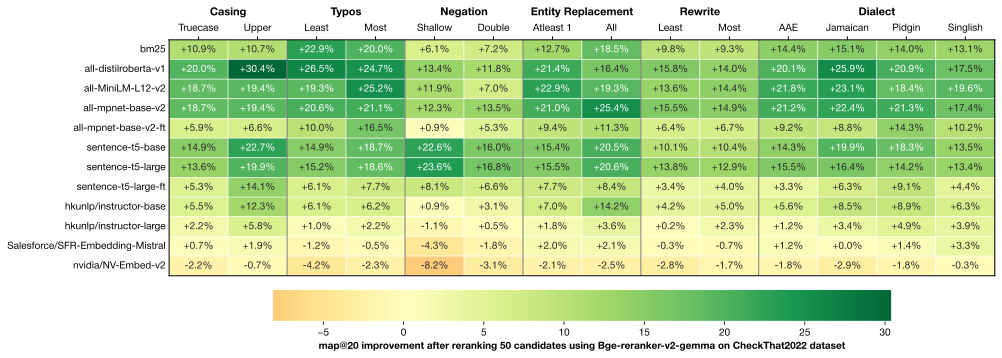

In [ ]:
recovery_check_that_df = plot_all_experiments_after(experiments_dict,
                                  model_order=custom_model_order, 
                                  res_path ='clef2021-checkthat-task2a--english/results/before_reranking_results_all.jsonl', 
                                  after_res_path = 'clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl',
                                  map_at = "map@50", 
                                  dataset="CheckThat2022",
                                  dialect_results_df=dialect_results_after)

Trying to open ../experiments/casing/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/casing/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/typos/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/typos/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/negation/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/negation/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/fact-check-tweet/results/before_rerank_results_all.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/rewrite/gpt4o/fact-check-tweet/results/before_rerank_res

/tmp/ipykernel_2234771/3435982814.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(


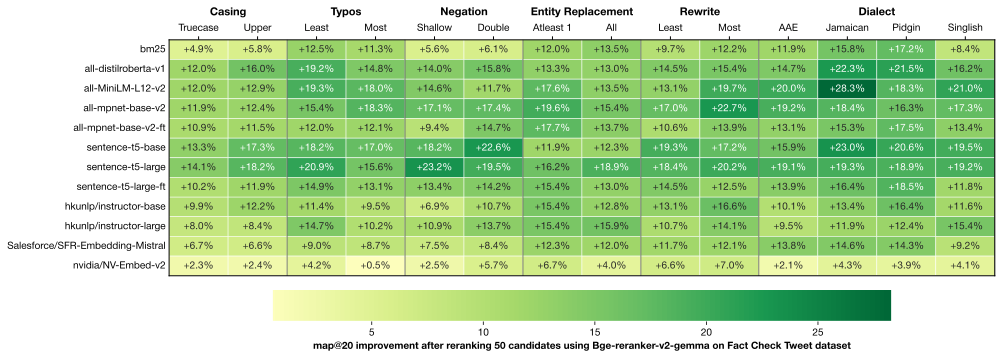

In [60]:
recovery_fact_check_tweet_df = plot_all_experiments_after(experiments_dict,
                                  model_order=custom_model_order, 
                                  res_path ='fact-check-tweet/results/before_rerank_results_all.jsonl', 
                                  after_res_path = 'fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl',
                                  map_at = "map@20", 
                                  dataset="Fact Check Tweet",
                                  dialect_results_df=dialect_results_after_fact_check)

Trying to open ../experiments/casing/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/typos/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/negation/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/rewrite/gpt4o/clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl


/tmp/ipykernel_2234771/3959759077.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(lambda x: f"{x:.1f}%" if not np.isnan(x) else "")


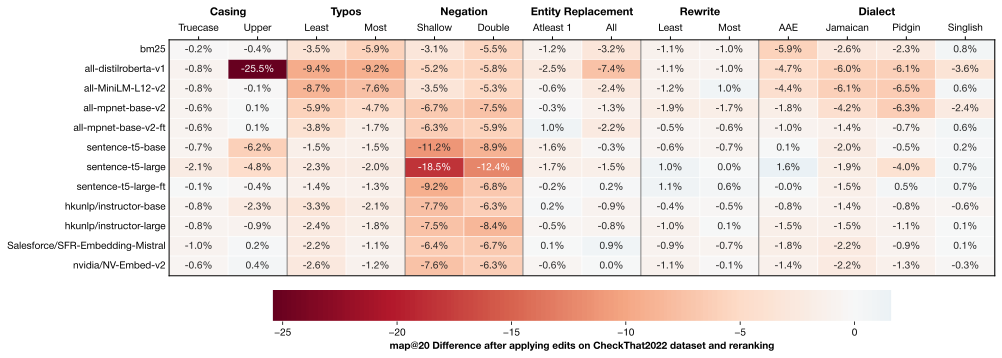

In [61]:
# e2e comparison
e2e_results_check_that_df = plot_all_experiments(experiments_dict, model_order=custom_model_order, res_path ='clef2021-checkthat-task2a--english/results/after_reranking_n_50_candidates_bge_llm_results.jsonl', map_at = "map@20", dataset="CheckThat2022", 
                                  after=True,
                                  dialect_results_df=e2e_dialect_map20,
                                  plot_title="after_reranking_results_all")

Trying to open ../experiments/casing/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/typos/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/negation/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/named_entity_replacement/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl
Trying to open ../experiments/rewrite/gpt4o/fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl


/tmp/ipykernel_2234771/3959759077.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = heatmap_df.applymap(lambda x: f"{x:.1f}%" if not np.isnan(x) else "")


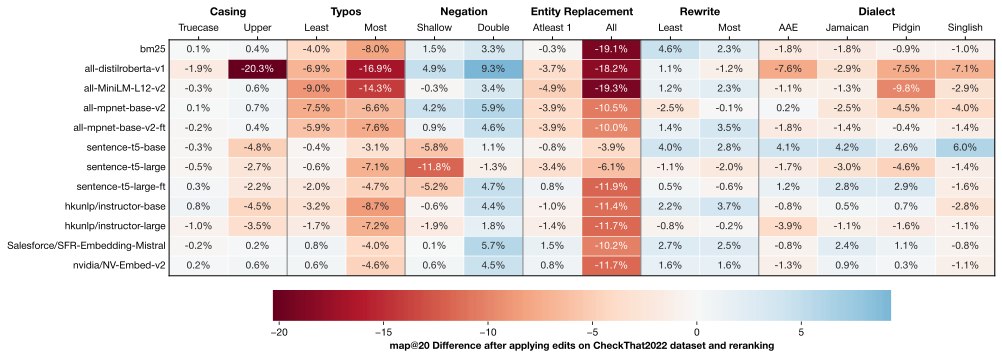

In [62]:
# e2e comparison
fact_check_tweet_e2e_results_df = plot_all_experiments(
                                  experiments_dict, 
                                  model_order=custom_model_order, 
                                  res_path ='fact-check-tweet/results/after_reranking_n_50_candidates_bge_llm_results.jsonl', map_at = "map@20", dataset="CheckThat2022", 
                                  after=True,
                                  dialect_results_df=e2e_dialect_map20_fact_check,
                                  plot_title="after_reranking_results_all")

In [63]:
# All the dataframes for fact-check-tweet
# fact_check_results_before_ranking
# recovery_fact_check_tweet_df
# fact_check_tweet_e2e_results_df

In [64]:
# Util function to generate latex gradient table for an experiment

# Arrange models in the desired order
custom_model_order = [
    "bm25",
    "all-distilroberta-v1",
    "all-MiniLM-L12-v2",
    "all-mpnet-base-v2",
    "all-mpnet-base-v2-ft",
    "sentence-t5-base",
    "sentence-t5-large",
    "sentence-t5-large-ft",
    "hkunlp/instructor-base",
    "hkunlp/instructor-large",
    "Salesforce/SFR-Embedding-Mistral",
    "nvidia/NV-Embed-v2"
]

# Dict containing name to be displayed in the latex table
model_name_mapping = {
    "bm25": "BM25",
    "all-distilroberta-v1": "all-distilroberta-v1",
    "all-MiniLM-L12-v2": "all-MiniLM-L12-v2",
    "all-mpnet-base-v2": "all-mpnet-base-v2",
    "all-mpnet-base-v2-ft": "all-mpnet-base-v2-ft",
    "sentence-t5-base": "sentence-t5-base",
    "sentence-t5-large": "sentence-t5-large",
    "sentence-t5-large-ft": "sentence-t5-large-ft",
    "hkunlp/instructor-base": "instructor-base",
    "hkunlp/instructor-large": "instructor-large",
    "Salesforce/SFR-Embedding-Mistral": "SFR-Embedding-Mistral",
    "nvidia/NV-Embed-v2": "NV-Embed-v2"
}

def generate_latex(results_df:pd.DataFrame, 
                   exclude_experiments:list = ['Amplify/Downplay'], 
                   custom_model_order:list = custom_model_order,
                   model_name_mapping:dict = model_name_mapping,
                   vmin:float = None,
                   vmax:float = None, 
                   pos_color_code = "pos", 
                   neg_color_code = "neg"):   
    # Filter out the excluded experiments
    filtered_df = results_df[~results_df['Experiment'].isin(exclude_experiments)]

    # Pivot table to create hierarchical columns (Experiment -> Type)
    heatmap_df = filtered_df.pivot_table(
        index="Model", columns=["Experiment", "Type"], values="Difference", sort=False
    )

    # Arrange heatmap models in the desired order
    heatmap_df = heatmap_df.reindex(custom_model_order) 

    # Get the values of the heatmap as a numpy array
    heatmap_values = heatmap_df.values

    # Normalize the 'Difference' values for color mapping
    if vmin is None:
        vmin = filtered_df["Difference"].min()

    if vmax is None:
        vmax = filtered_df["Difference"].max()
    midpoint = 0  # Midpoint for color gradient

    # Print the vmin and vmax values - for debuGGINH
    # print(f"vmin: {vmin}, vmax: {vmax}")

    rows = []
    for idx, values in enumerate(heatmap_values):
        model_name = custom_model_order[idx]
        formatted_values = [
            f"\\midpointgradientcell{{{value:.1f}}}{{{vmin}}}{{{vmax}}}{{0}}{{{neg_color_code}}}{{{pos_color_code}}}{{\\opacity}}{{0}}"
            for value in values
        ]
        # Create a new row using the template
        new_row = f"&\\texttt{{{model_name_mapping[model_name]}}} & " + " & ".join(formatted_values) + " \\\\"
        rows.append(new_row)

    # Join all rows into a single string and print it
    table = "\n".join(rows)
    return table, vmin, vmax

In [67]:
before_reranking_table, before_reranking_vmin, before_reranking_vmax = generate_latex(check_that_before_ranking_results_df, exclude_experiments=['Amplify/Downplay'])
print(before_reranking_table)

&\texttt{BM25} & \midpointgradientcell{0.0}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{0.0}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-14.9}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-14.9}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{0.4}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-2.6}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-2.8}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-12.4}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-0.8}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-0.3}{-35.25887592155312}{5.2892068921355895}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-

In [67]:
recovery_table, recovery_vmin, recovery_vmax = generate_latex(
    recovery_check_that_df, 
    exclude_experiments=['Amplify/Downplay'],
    pos_color_code="rerank_pos",
    vmin=None,
    vmax=None)
print(recovery_table)

&\texttt{BM25} & \midpointgradientcell{10.9}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{10.7}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{22.9}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{20.0}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{6.1}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{7.2}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{12.7}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{18.5}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{9.8}{-8.17700156985872}{30.40889991254764}{0}{neg}{rerank_pos}{\opacity}{0} & \midpointgradientcell{9.3}{-8.17700156985872}{30.40889991254764}{0}{neg}{rera

In [62]:
overall_pipe_table, overall_vmin, overall_vmax = generate_latex(
    e2e_results_check_that_df, 
    vmin=before_reranking_vmin,
    vmax=before_reranking_vmax,
    exclude_experiments=['Amplify/Downplay'])
print(overall_pipe_table)

&\texttt{BM25} & \midpointgradientcell{-0.2}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-0.4}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-3.5}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-5.9}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-3.1}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-5.5}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-1.2}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-3.2}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-1.1}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgradientcell{-1.0}{-23.848091716452235}{10.495444659452357}{0}{neg}{pos}{\opacity}{0} & \midpointgrad

In [12]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import cmcrameri.cm as cmc
import numpy as np
import json

def parse_map_differences(file_path: str):
    """
    Parses a single JSON file to calculate MAP@20 differences.
    """
    results = []
    with open(file_path, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    
    data = {}
    for entry in results:
        dialect = entry['dialect']
        for model, values in entry.items():
            if model == "dialect":
                continue
            
            original_baseline = values["original_baseline"]["map_results"]["test"][-1]
            edited_baseline = values["edited_baseline"]["map_results"]["test"][-1]
            difference = (edited_baseline - original_baseline) * 100  # Scale to %
            
            if model not in data:
                data[model] = {}
            data[model][dialect] = round(difference, 2)
    
    return pd.DataFrame(data).T

def plot_map_differences(json_files_dict, output_path:str, model_order=None):
    """
    Plots a heatmap of MAP differences for multiple experiments and dialects.

    Args:
        json_files_dict (dict): Mapping of experiment names to JSON file paths.
        model_order (list): Optional ordering of model names.
    """
    # Set global font
    matplotlib.rcParams['font.family'] = 'Helvetica Neue'

    # Parse data from all experiments
    all_results = []
    for experiment_name, file_path in json_files_dict.items():
        df = parse_map_differences(file_path)
        df = df.rename_axis("Model").reset_index()
        df["Experiment"] = experiment_name
        all_results.append(df)

    # Combine all experiment data into a single DataFrame
    combined_df = pd.concat(all_results, ignore_index=True)
    combined_df = combined_df.melt(id_vars=["Model", "Experiment"], var_name="Dialect", value_name="MAP_Difference")

    # Pivot the data for heatmap
    heatmap_data = combined_df.pivot_table(index="Model", columns=["Dialect"], values="MAP_Difference")

    # Reorder models if specified
    if model_order:
        heatmap_data = heatmap_data.reindex(model_order)

    # Annotate with formatted values
    annot_data = heatmap_data.applymap(lambda x: f"{x:.1f}%" if not pd.isna(x) else "")

    # Plot the heatmap
    cmap = cmc.vik_r  # Diverging colormap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        heatmap_data,
        cmap=cmap,
        center=0,
        annot=annot_data,
        fmt="",
        linewidths=0.5,
        cbar_kws={"orientation": "horizontal", "shrink": 0.8}
    )

    # Add title and format
    ax.set_ylabel("Models")
    ax.xaxis.tick_top()  # Move column labels to the top
    ax.xaxis.set_label_position("top")
    ax.set_xlabel("")  # Remove xlabel


    # Add a border around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")  # Save with high DPI
    plt.show()

In [13]:
# file_path = "../experiments/dialect/gpt4o/clef2021-checkthat-task2a--english/results/before_reranking_dialect_results.jsonl"
# json_files = {
#     'experiment': file_path

# }
# output_path= 'dialect_map_differences.png'
# plot_map_differences(json_files, output_path, custom_model_order)

In [115]:
# Change setting to allow dataframe to be printed in full witdh
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

In [118]:
baseline_named_entity_replacement = pd.read_csv("/home/kebl7383/claim-matching-robustness/experiments/named_entity_replacement/gpt4o/cl/orig_worstcase_named_entity_replacements.tsv", sep="\t") 
edited_named_entity_replacement = pd.read_csv("/home/kebl7383/claim-matching-robustness/experiments/named_entity_replacement/gpt4o/fact-check-tweet/edited_worstcase_named_entity_replacements.tsv", sep="\t")  
# Merge the two dataframes
merged_df = pd.merge(baseline_named_entity_replacement, edited_named_entity_replacement, on="query_id", suffixes=('_baseline', '_edited'))

In [119]:
merged_df.sample(20)

,query_id,query_baseline,query_edited
14,1287265632778518016,"The worst is yet to come. Infection wise, and economy wise. Massive closures and job losses loom ahead. Rising NPAs. Wonder if any banks will become distressed. Then, Government may re introduce the FRDI bill.","The worst is yet to come. Infection wise, and economy wise. Extensive closures and employment reductions loom ahead. Escalating NPAs. Wonder if any lending firms will become unstable. Then, the administration might reinstate the FRDI proposal."
10,1161099192355474944,"Does CNN’s head of PR still think “Fredo” is an ethnic slur after watching this? Because if it’s the N word for Italians likesays, I don’t understand why Chris seems so at ease with someone saying it here. An excuse just as fake as his news. #FredoCuomo","Does MSNBC's communication director still think “Fredo” is an ethnic slur after watching this? Because if it’s the N word for Italians like says, I don’t understand why Tony seems so at ease with someone saying it here. An excuse just as fake as his news. #FredoSoprano"
160,1232377630801965056,The Coronavirus is not contained. It will not fade in the spring. Trump cut CDC by 9 percent. Trump eliminated the position at the global health security teams at NSC and DHS. They don’t know what they are doing. They are fixated on the politics and the stock market.,The pandemic is not under control. It won't disappear by summer. The former president cut CDC funds by almost 10 percent. The leader also removed a key position at international health safety teams at NSA and FEMA. They're obsessed with politics and Wall Street.
49,1295422068343869184,"The removal of mailboxes is not stopping. A posted this from Southfield,Michigan post office.","The removal of letterboxes is not stopping. A posted this from Seattle, Washington postal facility."
95,1254721721518771968,"_perki Hi Antony, this post is fake and didn't come from us. We are not reopening today and have no confirmed plans at this time. When we do, any official announcements will come from our Social Media channels and our website.","_perki Hello Antony, this message is false and did not originate from us. We are not starting operations today and have no scheduled plans currently. When we do, any formal statements will be shared via our Instagram and our homepage."
47,1282765273645240064,Can a passenger be charged with distracted driving in a vehicle? Q&amp;Eh? #OPPTips,"Is it possible for someone in the passenger seat to be fined for causing distraction in a car? Eh, Newfoundlanders? #NLTrafficTips"
22,907439522962722816,"Astonishing that Congress VP, Rahul Gandhi goes to US and slams his own Country,India ..It's frustration of Rahul speaking..Deplorable!","Shocking that Labour Party VP, Keir Starmer goes to Canada and criticizes his own Country, the UK.. It's frustration of Keir speaking.. Disgraceful!"
144,1208362613417095168,RSS POLICE WITHOUT NAME BATCH. Sare police waale ke name batch gir gaye..that's how RSS people also entered police team n rest all knows.,"BJP POLICE WITHOUT ID LABELS. Many officers' ID labels fell off..that's how BJP affiliates also merged into police teams, and everyone knows the rest."
117,1241728232912634112,_mvishnugrrr! It is 2000 crore. Our HL had a typo!!!!,@_mvishnugrrr! It is 2000 crore. Our Finance Minister had a typo!!!!
122,1219623362739215872,SCAM 🚨 There is a new scam where you get a text with your name from Fedex (or another delivery service)and a tracking number. Do not click on the link. When in doubt about a tracking number go to the main website of the shipping company and search the tracking number yourself,"SCAM 🚨 Watch out for a new fraud where you receive a text with your name from UPS (or any shipping service) along with a tracking number. Avoid clicking the link. If unsure about a tracking number, visit the carrier's main website and verify the tracking number yourself."


In [14]:
# import os
# import jsonlines
# import matplotlib.pyplot as plt

# # Define the directory containing JSONL files
# data_dir = "../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/results"  # Update this to your directory path
# n_candidates_list = [5, 10, 20, 50, 100]

# # Store absolute differences for plotting
# baseline_differences = {n: [] for n in n_candidates_list}
# worstcase_differences = {n: [] for n in n_candidates_list}

# for n_candidates in n_candidates_list:
#     file_path = os.path.join(data_dir, f"after_reranking_n_candidates_{n_candidates}_results.jsonl")
    
#     if not os.path.exists(file_path):
#         print(f"File {file_path} not found. Skipping...")
#         continue

#     # Open and read the JSONL file
#     with jsonlines.open(file_path) as reader:
#         for obj in reader:
#             for model, data in obj.items():
#                 # Extract map@5 values
#                 original_baseline_map5 = data["original_baseline"]["map_results"]["test"][1]
#                 edited_baseline_map5 = data["edited_baseline"]["map_results"]["test"][1]
#                 original_worstcase_map5 = data["original_worstcase"]["map_results"]["test"][1]
#                 edited_worstcase_map5 = data["edited_worstcase"]["map_results"]["test"][1]

#                 # Calculate absolute differences
#                 baseline_diff = original_baseline_map5 - edited_baseline_map5
#                 worstcase_diff = original_worstcase_map5 - edited_worstcase_map5
                
#                 # Append to lists
#                 baseline_differences[n_candidates].append(baseline_diff)
#                 worstcase_differences[n_candidates].append(worstcase_diff)

# # Prepare data for plotting
# baseline_plot_data = [sum(baseline_differences[n]) for n in n_candidates_list]
# worstcase_plot_data = [sum(worstcase_differences[n]) for n in n_candidates_list]

# # Step 2: Plot the Results
# plt.figure(figsize=(8, 5))

# # Plot baseline and worstcase
# plt.plot(
#     n_candidates_list, 
#     baseline_plot_data, 
#     marker='o', 
#     markersize=8,  # Thicker markers
#     label="Baseline (MAP@5)", 
#     linestyle='-'
# )
# plt.plot(
#     n_candidates_list, 
#     worstcase_plot_data, 
#     marker='x', 
#     markersize=8,  # Thicker markers
#     label="Worstcase (MAP@5)", 
#     linestyle='--'
# )

# # Add a horizontal line at y=0
# plt.axhline(0, color='gray', linestyle=':', linewidth=1)

# # Add grid with dotted lines
# plt.grid(linestyle=':')

# # Configure the plot
# plt.title("Absolute Difference in MAP@5 for Different n_candidates")
# plt.xlabel("n_candidates")
# plt.ylabel("Absolute Difference in MAP@5")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [5]:
import os
import jsonlines
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cmcrameri.cm as cmc
from typing import List


def plot_comparison(data_dir: str, n_candidates_list: list, transformation_name: str):

    # Store MAP@5 values for plotting
    original_baseline_map5_values = {n: [] for n in n_candidates_list}
    edited_baseline_map5_values = {n: [] for n in n_candidates_list}
    original_worstcase_map5_values = {n: [] for n in n_candidates_list}
    edited_worstcase_map5_values = {n: [] for n in n_candidates_list}

    for n_candidates in n_candidates_list:
        file_path = os.path.join(data_dir, f"after_reranking_n_candidates_{n_candidates}_results.jsonl")
        
        if not os.path.exists(file_path):
            print(f"File {file_path} not found. Skipping...")
            continue

        # Open and read the JSONL file
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                for model, data in obj.items():
                    # Extract map@5 values
                    original_baseline_map5 = data["original_baseline"]["map_results"]["test"][1] * 100  # Convert to percentage
                    edited_baseline_map5 = data["edited_baseline"]["map_results"]["test"][1] * 100  # Convert to percentage
                    original_worstcase_map5 = data["original_worstcase"]["map_results"]["test"][1] * 100  # Convert to percentage
                    edited_worstcase_map5 = data["edited_worstcase"]["map_results"]["test"][1] * 100  # Convert to percentage

                    # Append MAP@5 values
                    original_baseline_map5_values[n_candidates].append(original_baseline_map5)
                    edited_baseline_map5_values[n_candidates].append(edited_baseline_map5)
                    original_worstcase_map5_values[n_candidates].append(original_worstcase_map5)
                    edited_worstcase_map5_values[n_candidates].append(edited_worstcase_map5)

    # Combined plot for baseline and worstcase
    fig, ax = plt.subplots(figsize=(8, 4))

    # Create equal spacing for x-axis labels
    x_positions = range(len(n_candidates_list))

    # Colormap for visual appeal
    cmap = cmc.navia_r
    baseline_color = cmap(0.3)  # Light color for baseline
    worstcase_color = cmap(0.6)  # Darker color for worstcase

    # Define unique markers for n_candidates
    markers = ['o', 's', '^', 'D', 'P', '*', 'h']  # Circle, square, triangle, diamond, plus

    # Plot for each n_candidates
    for i, n_candidates in enumerate(n_candidates_list):
        # Offset positions for baseline and worstcase
        baseline_position = x_positions[i] - 0.15  # Slightly left
        worstcase_position = x_positions[i] + 0.15  # Slightly right

        # Baseline original markers
        ax.scatter([baseline_position] * len(original_baseline_map5_values[n_candidates]),
                original_baseline_map5_values[n_candidates],
                label="Baseline" if i == 0 else "",  # Add label only once
                marker=markers[i],
                color=baseline_color, edgecolor="black", alpha=0.8)
        
        # Baseline box plot
        all_baseline_values = original_baseline_map5_values[n_candidates] + edited_baseline_map5_values[n_candidates]
        box = ax.boxplot(
            all_baseline_values,
            positions=[baseline_position],
            widths=0.2,
            vert=True,
            showmeans=False,
            patch_artist=True  # Fill the box with color
        )
        for patch in box['boxes']:
            patch.set_facecolor(baseline_color)
            patch.set_alpha(0.7)
        for median in box.get('medians', []):
            median.set_visible(False)

        # Worstcase original markers
        ax.scatter([worstcase_position] * len(original_worstcase_map5_values[n_candidates]),
                original_worstcase_map5_values[n_candidates],
                label="Worstcase" if i == 0 else "",  # Add label only once
                marker=markers[i],
                color=worstcase_color, edgecolor="black", alpha=0.8)
        
        # Worstcase box plot
        all_worstcase_values = original_worstcase_map5_values[n_candidates] + edited_worstcase_map5_values[n_candidates]
        box = ax.boxplot(
            all_worstcase_values,
            positions=[worstcase_position],
            widths=0.2,
            vert=True,
            showmeans=False,
            patch_artist=True  # Fill the box with color
        )
        for patch in box['boxes']:
            patch.set_facecolor(worstcase_color)
            patch.set_alpha(0.7)
        for median in box.get('medians', []):
            median.set_visible(False)

    # Configure plot
    ax.set_title(f"Baseline and Worstcase MAP@5 Across Candidates for {transformation_name}", fontsize=12)
    ax.set_xlabel("Number of Candidates", fontsize=10)
    ax.set_ylabel("MAP@5 (%)", fontsize=10)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(n_candidates_list, fontsize=10)
    ax.grid(linestyle=':', alpha=0.6)
    ax.legend(fontsize=10, frameon=False)

    # Final adjustments
    plt.tight_layout()
    plt.show()

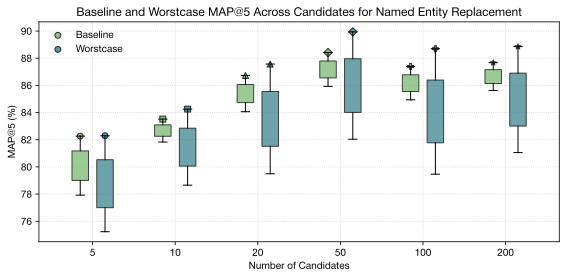

In [9]:
# Define the directory containing JSONL files
data_dir = "../experiments/named_entity_replacement/gpt4o/clef2021-checkthat-task2a--english/results" 
n_candidates_list = [5, 10, 20, 50, 100, 200]
plot_comparison(data_dir, n_candidates_list, transformation_name="Named Entity Replacement")

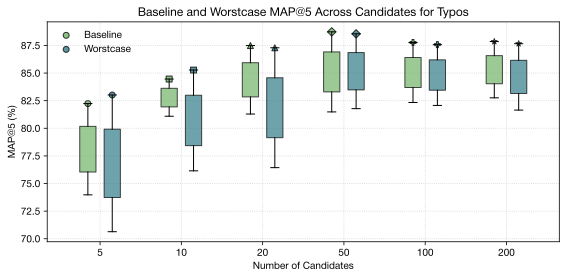

In [24]:
# Define the directory containing JSONL files
data_dir = "../experiments/typos/gpt4o/clef2021-checkthat-task2a--english/results" 
n_candidates_list = [5, 10, 20, 50, 100, 200]
plot_comparison(data_dir, n_candidates_list, transformation_name="Typos")

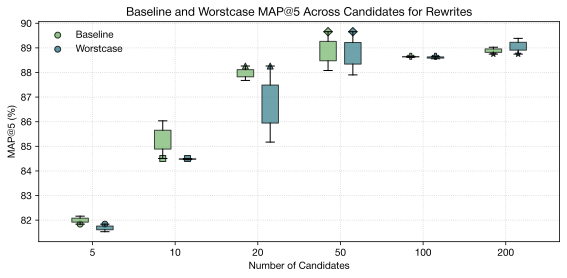

In [10]:
# Define the directory containing JSONL files
data_dir = "../experiments/rewrite/gpt4o/clef2021-checkthat-task2a--english/results" 
n_candidates_list = [5, 10, 20, 50, 100, 200]
plot_comparison(data_dir, n_candidates_list, transformation_name="Rewrites")

In [17]:
import os
import jsonlines
import matplotlib.pyplot as plt
import numpy as np

def plot_baseline_performance(data_dir: str, n_candidates_list: list, transformation_name: str, output_file):
    """
    Plots a bar chart showing the original baseline MAP@5 performance across different numbers of candidates,
    treating the x-axis as categorical to avoid scaling differences.
    
    Parameters:
        data_dir (str): Directory containing the JSONL result files.
        n_candidates_list (list): List of candidate numbers (top-k values).
        transformation_name (str): Name of the transformation (used in the title).
    """
    
    # Store MAP@5 values for the baseline model
    baseline_map5_values = []

    for n_candidates in n_candidates_list:
        file_path = os.path.join(data_dir, f"after_reranking_n_{n_candidates}_appendix.jsonl")
        
        if not os.path.exists(file_path):
            print(f"File {file_path} not found. Skipping...")
            baseline_map5_values.append(None)  # Append None for missing data
            continue

        # Read the JSONL file
        map5_scores = []
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                for model, data in obj.items():
                    # Extract original baseline MAP@5 (converted to percentage)
                    map5_scores.append(data["original_baseline"]["map_results"]["test"][1] * 100)

        # Store the mean MAP@5 for the given number of candidates
        if map5_scores:
            baseline_map5_values.append(np.mean(map5_scores))
        else:
            baseline_map5_values.append(None)

    # Filter out missing data
    valid_indices = [i for i, v in enumerate(baseline_map5_values) if v is not None]
    valid_n_candidates = [n_candidates_list[i] for i in valid_indices]
    valid_map5_values = [baseline_map5_values[i] for i in valid_indices]

    # Treat the number of candidates as categorical
    x_positions = np.arange(len(valid_n_candidates))  # Create categorical x-axis positions

    # Plot settings
    plt.figure(figsize=(6, 4))
    cmap = cmc.navia
    baseline_color = cmap(0.3) 
    bar_width = 0.7  # Increased bar width
    plt.bar(x_positions, valid_map5_values, color=baseline_color, alpha=0.8, edgecolor="black", width=bar_width)

    # Identify the top performer
    max_value = max(valid_map5_values)
    max_index = valid_map5_values.index(max_value)

    # Add text labels on top of bars (with an asterisk for the top performer)
    for i, v in enumerate(valid_map5_values):
        label = f"{v:.1f}" + (" *" if i == max_index else "")
        plt.text(x_positions[i], v + 0.5, label, ha="center", fontsize=16, fontweight="bold" if i == max_index else "normal")

    # Configure categorical x-axis
    plt.xlabel("Number of Candidates (top-j)", fontsize=20)
    plt.ylabel("MAP@5 (%)", fontsize=20)
    # plt.title(f"Baseline MAP@5 Performance Across Candidates ({transformation_name})", fontsize=14)

    plt.xticks(x_positions, valid_n_candidates, fontsize=18)  # Treat as categorical
    plt.yticks(fontsize=20)

    # Set y-axis to start from 50
    plt.ylim(70, max(valid_map5_values) + 5)

    # Remove y-grid for a cleaner look
    plt.grid(axis="y", linestyle=":", alpha=0.6)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

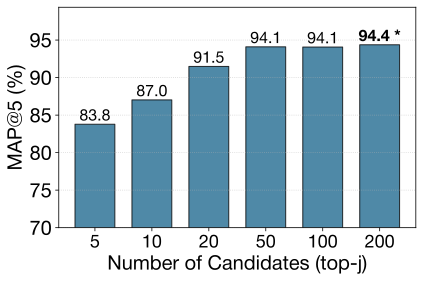

In [18]:
# Define the directory containing JSONL files
data_dir = "../experiments/rewrite/gpt4o/clef2021-checkthat-task2a--english/results" 
n_candidates_list = [5, 10, 20, 50, 100, 200]
plot_baseline_performance(data_dir, n_candidates_list, transformation_name="Typos", output_file="baseline_performance_bge.pdf")

In [4]:
!python -m pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 21.1 MB/s eta 0:00:00 0:00:01


In [11]:
import os
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa

In [26]:
test_df = pd.read_csv('../annotations/annotator1/dialect_for_annotation.csv')

In [27]:
test_df.shape

(20, 6)

In [29]:
import os
import numpy as np
import pandas as pd

# Define the main annotations folder
annotations_folder = "../annotations"

# Define perturbation types
perturbation_types = [
    "dialect_for_annotation.csv",
    "entity_for_annotation.csv",
    "typos_for_annotation.csv"
]

# Expected number of queries per file
expected_count = 20

# Initialize a dictionary to store results
results = {}

for perturbation in perturbation_types:
    dataframes = {}
    
    for annotator in ["annotator1", "annotator2", "annotator3"]:
        file_path = os.path.join(annotations_folder, annotator, perturbation)
        df = pd.read_csv(file_path)
        
        # Check completeness by verifying the number of rows
        if len(df) != expected_count:
            print(f"WARNING: {annotator}'s file for {perturbation} is incomplete: found {len(df)} rows (expected {expected_count}).")
        dataframes[annotator] = df.reset_index(drop=True)
    
    # Merge on index by creating a new DataFrame for perturbation_accuracy
    perturbation_accuracy_df = pd.DataFrame({
        "annotator1": dataframes["annotator1"]["perturbation_accuracy"],
        "annotator2": dataframes["annotator2"]["perturbation_accuracy"],
        "annotator3": dataframes["annotator3"]["perturbation_accuracy"]
    })
    
    # Compute majority perturbation accuracy:
    # A query is considered valid only if all three annotators mark it as valid (i.e., value 1).
    perturbation_accuracy_df["majority_perturbation_accuracy"] = (
        perturbation_accuracy_df.sum(axis=1) == 3
    ).astype(int)
    
    # Print queries (by index) where the majority perturbation accuracy is not 1
    non_valid_queries = perturbation_accuracy_df[perturbation_accuracy_df["majority_perturbation_accuracy"] != 1]
    if not non_valid_queries.empty:
        print(f"Perturbation: {perturbation}")
        print("Queries where majority perturbation accuracy is not 1:")
        print(non_valid_queries)
        print()
    
    # Store the results
    results[perturbation] = {
        "total_queries": len(perturbation_accuracy_df),
        "average_perturbation_accuracy": perturbation_accuracy_df["majority_perturbation_accuracy"].mean()
    }

# (Optional) Print the final aggregated results
for perturbation, metrics in results.items():
    print(f"Perturbation: {perturbation}")
    print(f"Total Queries: {metrics['total_queries']}")
    print(f"Average Perturbation Accuracy (Majority): {metrics['average_perturbation_accuracy']:.3f}\n")


Perturbation: entity_for_annotation.csv
Queries where majority perturbation accuracy is not 1:
    annotator1  annotator2  annotator3  majority_perturbation_accuracy
4            1         NaN           1                               0
6            1         1.0           0                               0
14           1         0.0           1                               0

Perturbation: dialect_for_annotation.csv
Total Queries: 20
Average Perturbation Accuracy (Majority): 1.000

Perturbation: entity_for_annotation.csv
Total Queries: 20
Average Perturbation Accuracy (Majority): 0.850

Perturbation: typos_for_annotation.csv
Total Queries: 20
Average Perturbation Accuracy (Majority): 1.000

